In [1]:
import pandas as pd
import os
import glob
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
import numpy as np
import umap
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from plotnine import ggplot, geom_point, aes, ggtitle, labs, theme, scale_color_brewer, geom_histogram
from sklearn.preprocessing import StandardScaler
import os.path
# def plot_dendrogram(model, plot_title, linkage, affinity, **kwargs):
#     # Create linkage matrix and then plot the dendrogram
#     # create the counts of samples under each node
#     figure(figsize=(30, 28))
#     plt.title(plot_title)

#     counts = np.zeros(model.children_.shape[0])
#     n_samples = len(model.labels_)
#     for i, merge in enumerate(model.children_):
#         current_count = 0
#         for child_idx in merge:
#             if child_idx < n_samples:
#                 current_count += 1  # leaf node
#             else:
#                 current_count += counts[child_idx - n_samples]
#         counts[i] = current_count

#     linkage_matrix = np.column_stack(
#         [model.children_, model.distances_, counts]
#     ).astype(float)

#     # Plot the corresponding dendrogram
#     dendrogram(linkage_matrix, **kwargs)
#     plt.xticks(fontsize=13)
#     plt.show()
#     plt.savefig(f"../figures/cancer_cohort_{plot_title}_linkage_{linkage}_affinity_{affinity}.png")

# def save_clustered_datafiles(model, data, cancer_type, distance_threshold, linkage, affinity):
#     os.makedirs("../data/processed_data/hierarchically_clustered_mutations/", exist_ok=True)
#     threshold_dir = f"../data/processed_data/hierarchically_clustered_mutations/{cancer_type}/linkage_{linkage}_affinity_" \
#                     f"{affinity}/dist_thresh_{distance_threshold}"
#     os.makedirs(threshold_dir,
#                 exist_ok=True)
#     for idx, label in enumerate(np.unique(model.labels_)):
#         patient_cluster = data.loc[model.labels_ == label]
#         patient_cluster.to_csv(f"{threshold_dir}/C{idx}.csv")
#         patient_cluster.sum(axis=0).to_csv(f"{threshold_dir}/aggregated_C{idx}.csv")

#     data.sum(axis=0).to_csv(f"{threshold_dir}/aggregated_all.csv")


# def cluster_data_and_display_clustering(distance_threshold, mutations_df, plot_title,
#                                         save_clusters=False, affinity="euclidean",
#                                         affinity_matrix=None, linkage="ward", no_labels=False):
#     model = AgglomerativeClustering(n_clusters=None,
#                                     distance_threshold=distance_threshold,
#                                     linkage=linkage)
#     if (affinity == "euclidean"):
#         model = model.fit(mutations_df)
#     elif (affinity == "pearson"):
#         try:
#             model = model.fit(affinity_matrix)
#         except:
#             print("affinity matrix musn't be None when affinity = 1-pearson")
#     plot_dendrogram(model,
#                     plot_title,
#                     linkage,
#                     affinity,
#                     truncate_mode="level",
#                     p=100,
#                     no_labels=no_labels,
#                     color_threshold=distance_threshold,
#                     above_threshold_color="black",
#                     labels = mutations_df.index.to_numpy())
#     if (save_clusters):
#         save_clustered_datafiles(model, mutations_df, plot_title, distance_threshold,
#                                  linkage, affinity)

def get_per_cohort_mutations(cancer_cohort):
    binned_mutation_files = glob.glob(f'../data/processed_data/per_patient_mutations/{cancer_cohort}/binned_mutations*')
    chr_keep = pd.read_csv("../data/processed_data/chr_keep.csv")
    df = pd.DataFrame(columns=chr_keep["chr"].to_numpy())

    for file in binned_mutation_files:
        patient_id = file.split("_")[-1].split(".")[0]
        patient_mutations = pd.read_csv(file)['x']
        df.loc[patient_id] = patient_mutations.values

    agg_mutation_df = pd.read_csv("../data/processed_data/mut_count_data.csv", index_col=0)
    regions_to_consider = agg_mutation_df.loc[~agg_mutation_df.isna().any(axis=1)].index.values
    df = df.loc[:, regions_to_consider]
    return df

def group_donors_by_subtype(mutation_df, annotation_df):
    mutation_df = mutation_df.reset_index(names = "donor_id")
    mutation_df.index = mutation_df["donor_id"].map(annotation_df.to_dict()["subtype"])
    mutation_df.index.name = ""
    return(mutation_df)

def create_cohort_df(grouped_donor_dfs):
    grouped_donor_dfs = pd.concat(grouped_donor_dfs)
    return(grouped_donor_dfs.reset_index(names="subtype"))

def reduce_mutation_dims(df, method, n_components, scale=True,
                         normalize_by_mut_counts=True):
    if (method == "PCA"):
        model = PCA(n_components=n_components)
    elif (method == "TSNE"):
        model = TSNE(n_components=n_components)
    elif(method == "UMAP"):
        model = umap.UMAP(n_components=n_components, random_state=1)

    if (normalize_by_mut_counts):
        df = np.log(df.div(np.sum(df, axis=1).array, axis=0) + 1)
    if (scale):
        df = StandardScaler().fit_transform(df)

    df_reduced = model.fit_transform(df)
    return([model, df_reduced])

def plot_reduced_dim_mutations(reduced_dim_data, components_to_plot,
                               mut_counts, plot_title, subtypes,
                               subtype_by_color=False):
    df = pd.DataFrame({"dim1": reduced_dim_data[:, 0],
                       "dim2": reduced_dim_data[:, 1],
                       "subtype": subtypes,
                       "mut_counts": mut_counts})
    if ("3" in components_to_plot[0] or "3" in components_to_plot[1]):
        df["dim3"] = reduced_dim_data[:, 2]
    
#     c25 = list(
#           "dodgerblue2", "#E31A1C", # red
#           "green4",
#           "#6A3D9A", # purple
#           "#FF7F00", # orange
#           "black", "gold1",
#           "skyblue2", "#FB9A99", # lt pink
#           "palegreen2",
#           "#CAB2D6", # lt purple
#           "#FDBF6F", # lt orange
#           "gray70", "khaki2",
#           "maroon", "orchid1", "deeppink1", "blue1", "steelblue4",
#           "darkturquoise", "green1", "yellow4", "yellow3",
#           "darkorange4", "brown"
#         )
    if (subtype_by_color):
        fig, plot = (
        ggplot(df, aes(components_to_plot[0], components_to_plot[1],
                color="subtype"))
         + geom_point(size=5)
         + ggtitle(plot_title)
         + labs(color="mutation counts")
         + theme(figure_size=(18, 13))
         + scale_color_brewer(type="qual", palette="Set1")
    ).draw(show=False, return_ggplot=True)
    else:
        fig, plot = (
            ggplot(df, aes(components_to_plot[0], components_to_plot[1], shape='subtype',
                    color=np.log(mut_counts)))
             + geom_point(size=3)
             + ggtitle(plot_title)
             + labs(color="mutation counts")
             + theme(figure_size=(18, 13))
        ).draw(show=False, return_ggplot=True)
    return(fig)

def get_top_variable_bins(df, n):
    stds = np.std(df)
    largest_variance_feat_idxs = np.argsort(stds)[::-1]
    top = df.iloc[:, largest_variance_feat_idxs].iloc[:, 0:n]
    return top

def drop_bottom_count_samples(df, n):
    mut_counts = np.sum(df.drop("subtype", axis=1), axis=1)
    bottom_count_idxs = np.argsort(mut_counts)[0:n]
    top = df.loc[set(df.index) - set(bottom_count_idxs)]
    return top


def perform_analysis(df, bottom_n_remove, n_highest_var_feats, method, n_components, 
                     scale, normalize_by_mut_counts, dims_to_plot, plot_title,
                    subtype_by_color=False):
    df = drop_bottom_count_samples(df, bottom_n_remove)
    subtype = df["subtype"]
    df = df.drop("subtype", axis=1)
    df = get_top_variable_bins(df, n_highest_var_feats)

    model, reduced_dim_data = reduce_mutation_dims(df, method, n_components, scale, 
                                                   normalize_by_mut_counts)
    fig = plot_reduced_dim_mutations(reduced_dim_data,
                                   [dims_to_plot[0], dims_to_plot[1]],
                                   np.sum(df, axis=1),
                                   plot_title,
                                   subtype,
                                   subtype_by_color)
    if subtype_by_color:
        subtype_by = "color"
    else:
        subtype_by = "shape"
    
    os.makedirs(f"../figures/dim_reduced_data/{plot_title}", exist_ok=True)
    fig.savefig(f'../figures/dim_reduced_data/{plot_title}/method_{method}-top_{n_highest_var_feats}_'
                f'features-no_bottom_{bottom_n_remove}_samples-scale_{scale}-norm_by_mut_counts_'
                f'{normalize_by_mut_counts}-dims_{dims_to_plot[0]}_and_{dims_to_plot[1]}-subtype_by_{subtype_by}.png',
                dpi=300)
    return(model)

def separate_rosa_cohort_and_donor_ids(rosa_annotations):
    cohorts_donors = rosa_annotations["donor_unique_id"].str.split("::").str
    cohorts = cohorts_donors.get(0)
    donor_ids = cohorts_donors.get(1)
    rosa_annotations["donor"] = donor_ids
    rosa_annotations["cohort"] = cohorts
    return(rosa_annotations)

def get_donors_by_cohort_rosa_df(rosa_annotations, cohort):
    return(rosa_annotations[rosa_annotations["cohort"] == cohort])

def get_idx_to_ICGC_map(rosa_annotations, cohort, rosa_donor_to_ICGC):
    m = rosa_annotations[rosa_annotations["cohort"] == 
                                      cohort]["donor"].map(
                        rosa_donor_to_ICGC.set_index("rosa_donor").to_dict()["ICGC_donor"])
    return(m)

def prep_annotation_df(rosa_annotations, cohort):
    df = rosa_annotations[rosa_annotations["cohort"] == cohort][["ICGC_donor_id", 
                                                           "histology_tier4"]].rename(
                                {"histology_tier4":"subtype"}, axis=1).set_index("ICGC_donor_id")
    return df

def prep_pre_cohort_grouping_df(cohort, rosa_annotations, mapped_icgc_id_file):
    df = get_per_cohort_mutations(cohort)
    specimen_df = pd.read_csv(f"../data/specimen.{cohort}.tsv", sep="\t")
    donor_ids = get_donors_by_cohort_rosa_df(rosa_annotations, cohort)["donor"]
    prev_ids_to_ICGC = pd.read_csv(f"../data/{mapped_icgc_id_file}", sep="\t")
    prev_ids_to_ICGC.columns = ["rosa_donor", "ICGC_donor"]
    prev_ids_to_ICGC_id = get_idx_to_ICGC_map(rosa_annotations, cohort, prev_ids_to_ICGC)
    rosa_annotations.loc[prev_ids_to_ICGC_id.index, "ICGC_donor_id"] = prev_ids_to_ICGC_id
    annotation_df = prep_annotation_df(rosa_annotations, cohort)
    df = group_donors_by_subtype(df, annotation_df)
    return(df)

def save_aggregated_subtyped_mutations(df, map_to_good_names):
    df["subtype"] = df["subtype"].map(map_to_good_names)
    df_agg = df.groupby("subtype").sum()
    df_agg = df_agg.T
    all_data_df_fp = "../data/processed_data/histologically_subtyped_mutations.csv"

    if (not os.path.isfile(all_data_df_fp)):
        df_agg.to_csv(all_data_df_fp)
        return

    all_data_df = pd.read_csv(all_data_df_fp, index_col=0)
    all_data_df.loc[:, df_agg.columns] = df_agg
    all_data_df.to_csv(all_data_df_fp)

In [2]:
rosa_annotations = pd.read_csv("../data/rosa_annotations.csv")
rosa_annotations = separate_rosa_cohort_and_donor_ids(rosa_annotations)

# Lung Meso

In [16]:
lung_meso = pd.read_csv("../data/processed_data/mesothelioma_per_patient_WGS_Waddell.csv", index_col=0)

In [17]:
subtypes = [patient[1] for patient in lung_meso.columns.str.split("_")]

In [18]:
lung_meso.columns = subtypes

In [19]:
lung_meso = lung_meso.T

In [20]:
all_lung = create_cohort_df([lung_meso, lung_squamous, lung_adeno])

NameError: name 'lung_squamous' is not defined

In [57]:
all_lung.to_csv("../data/processed_data/mutations_with_subtypes/all_lung.csv",
                 index=False)

In [43]:
lung_meso.to_csv("../data/processed_data/mutations_with_subtypes/lung_meso.csv",
                 index=False)

<ipython-input-1-eefe1d06eded>:178: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.


PCA(n_components=2)

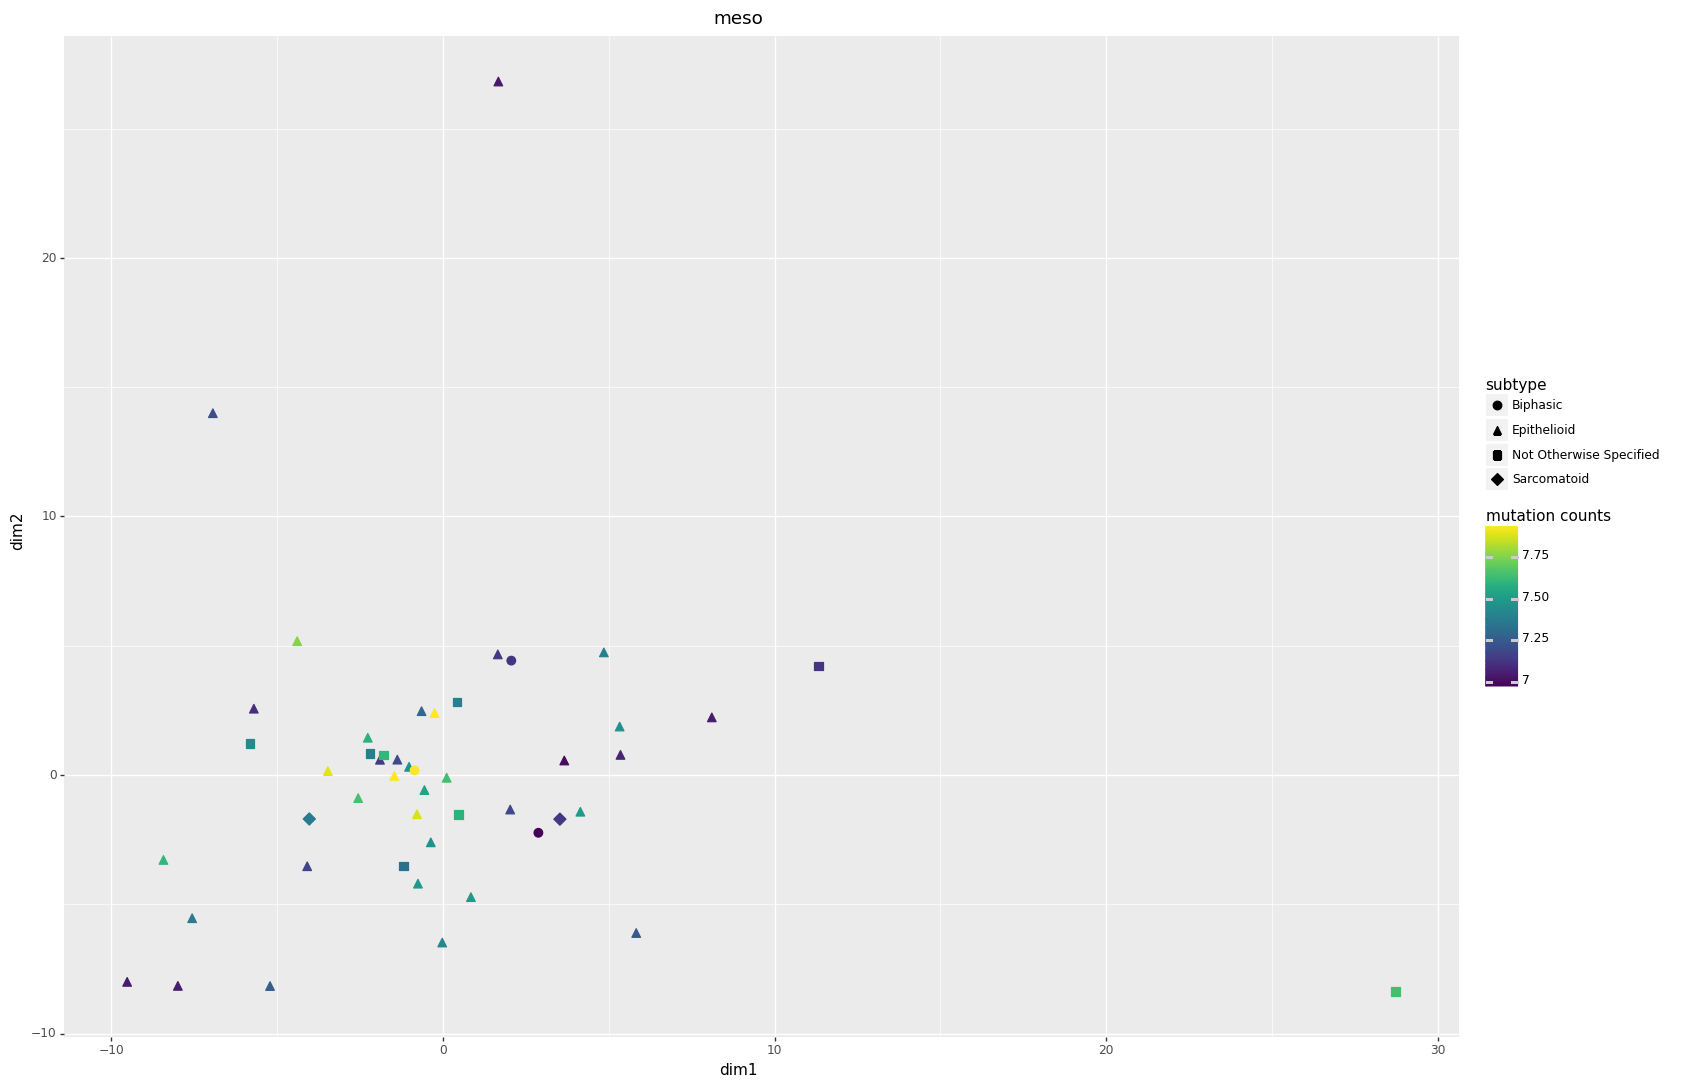

In [42]:
perform_analysis(df=lung_meso, 
                 bottom_n_remove=10, 
                 n_highest_var_feats=1000, 
                 method="PCA", 
                 n_components=2, 
                 scale=True, 
                 normalize_by_mut_counts=True, 
                 dims_to_plot=["dim1", "dim2"], 
                 plot_title="meso",
                 subtype_by_color=False)

# Lung Squamous Vs Adeno

In [3]:
LUAD_US = get_per_cohort_mutations("LUAD-US")
LUSC_US = get_per_cohort_mutations("LUSC-US")
LUAD_US_annotation = pd.DataFrame(["Adeno"] * len(LUAD_US.index), index=LUAD_US.index,
                                 columns = ["subtype"])
LUSC_US_annotation = pd.DataFrame(["Squamous"] * len(LUSC_US.index), index=LUSC_US.index,
                                 columns = ["subtype"])

lung_adeno = group_donors_by_subtype(LUAD_US, LUAD_US_annotation)
lung_squamous = group_donors_by_subtype(LUSC_US, LUSC_US_annotation)
lung = create_cohort_df([lung_adeno, lung_squamous])
lung.to_csv("../data/processed_data/mutations_with_subtypes/lung.csv", index=False)

In [ ]:
perform_analysis(df=lung, 
                 bottom_n_remove=10, 
                 n_highest_var_feats=1000, 
                 method="PCA", 
                 n_components=2, 
                 scale=True, 
                 normalize_by_mut_counts=True, 
                 dims_to_plot=["dim1", "dim2"], 
                 plot_title="Lung",
                 subtype_by_color=False)

# Lung Subtypes

In [7]:
LUAD_US = get_per_cohort_mutations("LUAD-US")
LUSC_US = get_per_cohort_mutations("LUSC-US")
Will_annotation = pd.read_csv("../data/TCGA_ICGCDonor_Subtype.txt", sep="\t", 
                             header=None, usecols=[1,2])
Will_annotation.columns = ["donor_id", "subtype"]
Will_annotation = Will_annotation.set_index("donor_id")

lung_adeno = group_donors_by_subtype(LUAD_US, Will_annotation)
lung_squamous = group_donors_by_subtype(LUSC_US, Will_annotation)
lung_squamous.index = pd.Series(lung_squamous.index).replace(np.nan, 'No label')
lung_subtypes = create_cohort_df([lung_squamous])
perform_analysis(df=lung_subtypes, 
                 bottom_n_remove=0, 
                 n_highest_var_feats=2128, 
                 method="UMAP", 
                 n_components=2, 
                 scale=True, 
                 normalize_by_mut_counts=True, 
                 dims_to_plot=["dim1", "dim2"], 
                 plot_title="Lung_subtypes",
                 subtype_by_color=True)

/home/mdanb/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
<ipython-input-1-91208d1088a2>:178: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
/home/mdanb/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3613: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
/home/mdanb/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version

TypeError: unsupported operand type(s) for /: 'str' and 'int'

In [63]:
sum(lung_subtypes["subtype"] == "mTOR.SOX2")

20

In [9]:
lung_subtypes.to_csv("../data/processed_data/mutations_with_subtypes/lung_squamous.csv", index=False)

In [8]:
lung_subtypes

,subtype,donor_id,chr1.5,chr1.6,chr1.7,chr1.8,chr1.9,chr1.11,chr1.12,chr1.15,...,chr9.123,chr9.124,chr9.125,chr9.126,chr9.127,chr9.131,chr9.132,chr9.133,chr9.135,chr9.137
0,mTOR.SOX2,DO26957,10,4,4,7,3,3,8,7,...,7,5,1,10,3,3,4,3,23,9
1,CellCycle,DO26692,5,3,3,2,0,4,4,1,...,1,5,1,6,2,6,4,1,5,4
2,AT.NKX2-1,DO26492,4,4,2,2,0,3,1,3,...,2,6,1,6,2,1,4,2,3,2
3,mTOR.SOX2,DO27588,10,4,4,2,0,1,2,7,...,3,2,3,4,2,5,9,1,7,3
4,mTOR.SOX2,DO26894,8,6,2,10,5,3,5,4,...,4,13,8,12,8,6,8,9,15,10
5,"KRT13,4.FOXA1",DO27484,26,35,11,15,11,9,4,10,...,6,6,3,10,3,4,5,7,13,5
6,mTOR.SOX2,DO26719,11,10,6,5,5,5,6,2,...,6,6,4,11,5,8,11,8,15,6
7,AT.NKX2-1,DO26475,7,2,8,3,5,1,5,3,...,2,2,4,3,2,2,1,3,9,8
8,No label,DO26769,24,27,8,19,8,11,13,12,...,24,10,3,21,11,12,10,5,19,16
9,"KRT13,4.FOXA1",DO27334,10,12,4,11,7,4,8,8,...,5,5,5,10,5,6,5,8,7,5


In [5]:
lung_subtypes

,subtype,chr1.5,chr1.6,chr1.7,chr1.8,chr1.9,chr1.11,chr1.12,chr1.15,chr1.16,...,chr9.123,chr9.124,chr9.125,chr9.126,chr9.127,chr9.131,chr9.132,chr9.133,chr9.135,chr9.137
0,mTOR.SOX2,10,4,4,7,3,3,8,7,6,...,7,5,1,10,3,3,4,3,23,9
1,CellCycle,5,3,3,2,0,4,4,1,1,...,1,5,1,6,2,6,4,1,5,4
2,AT.NKX2-1,4,4,2,2,0,3,1,3,3,...,2,6,1,6,2,1,4,2,3,2
3,mTOR.SOX2,10,4,4,2,0,1,2,7,2,...,3,2,3,4,2,5,9,1,7,3
4,mTOR.SOX2,8,6,2,10,5,3,5,4,6,...,4,13,8,12,8,6,8,9,15,10
5,"KRT13,4.FOXA1",26,35,11,15,11,9,4,10,6,...,6,6,3,10,3,4,5,7,13,5
6,mTOR.SOX2,11,10,6,5,5,5,6,2,6,...,6,6,4,11,5,8,11,8,15,6
7,AT.NKX2-1,7,2,8,3,5,1,5,3,3,...,2,2,4,3,2,2,1,3,9,8
8,No label,24,27,8,19,8,11,13,12,10,...,24,10,3,21,11,12,10,5,19,16
9,"KRT13,4.FOXA1",10,12,4,11,7,4,8,8,3,...,5,5,5,10,5,6,5,8,7,5


<ipython-input-93-eefe1d06eded>:178: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
/home/mdanb/.local/lib/python3.8/site-packages/mizani/palettes.py:397: UserWarning: Warning message:Brewer palette Set1 has a maximum of 9 colors Returning the palette you asked for with that many colors
/home/mdanb/.local/lib/python3.8/site-packages/mizani/palettes.py:397: UserWarning: Warning message:Brewer palette Set1 has a maximum of 9 colors Returning the palette you asked for with that many colors


UMAP(random_state=1, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

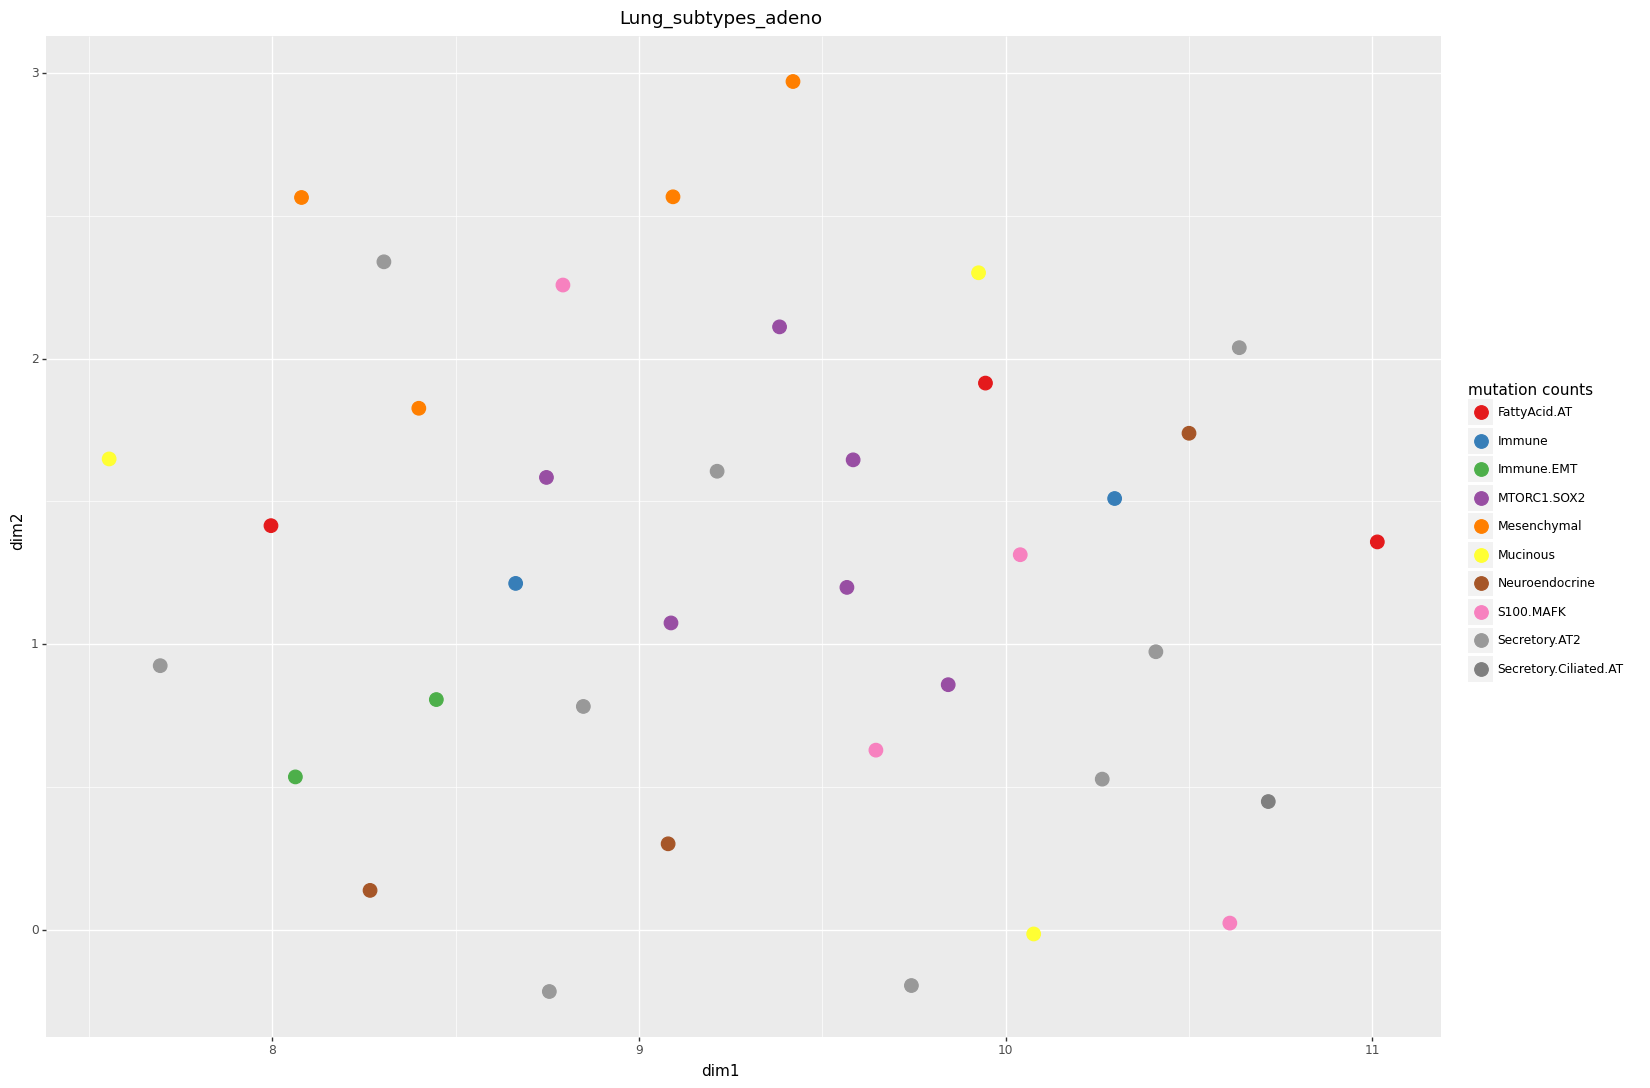

In [97]:
lung_subtypes = create_cohort_df([lung_adeno])
lung_subtypes.to_csv("../data/processed_data/mutations_with_subtypes/lung_adeno.csv", index=False)
perform_analysis(df=lung_subtypes, 
                 bottom_n_remove=0, 
                 n_highest_var_feats=2128, 
                 method="UMAP", 
                 n_components=2, 
                 scale=True, 
                 normalize_by_mut_counts=True, 
                 dims_to_plot=["dim1", "dim2"], 
                 plot_title="Lung_subtypes_adeno",
                 subtype_by_color=True)

In [36]:
squamous_subtypes_and_lung_adeno = create_cohort_df([lung_adeno, lung_squamous])

In [37]:
squamous_subtypes_and_lung_adeno["subtype"].unique()

array(['Adeno', 'mTOR.SOX2', 'CellCycle', 'AT.NKX2-1', 'KRT13,4.FOXA1',
       'No label', 'S100A.HES2', 'COL.SOX4'], dtype=object)

In [41]:
squamous_subtypes_and_lung_adeno.to_csv("../data/processed_data/mutations_with_subtypes/squamous_subtypes_and_lung_adeno.csv",
                                       index=False)

# SCLC

In [112]:
LUAD_US = get_per_cohort_mutations("LUAD-US")
LUSC_US = get_per_cohort_mutations("LUSC-US")
# LUAD_US_annotation = pd.DataFrame(["Adeno"] * len(LUAD_US.index), index=LUAD_US.index,
#                                  columns = ["subtype"])
# LUSC_US_annotation = pd.DataFrame(["Squamous"] * len(LUSC_US.index), index=LUSC_US.index,
#                                  columns = ["subtype"])

# lung_adeno = group_donors_by_subtype(LUAD_US, LUAD_US_annotation)
# lung_squamous = group_donors_by_subtype(LUSC_US, LUSC_US_annotation)
# lung = create_cohort_df([lung_adeno, lung_squamous])

In [118]:
LUAD_US

,chr1.5,chr1.6,chr1.7,chr1.8,chr1.9,chr1.11,chr1.12,chr1.15,chr1.16,chr1.19,...,chr9.123,chr9.124,chr9.125,chr9.126,chr9.127,chr9.131,chr9.132,chr9.133,chr9.135,chr9.137
DO23687,0,0,0,1,1,0,2,1,0,0,...,1,2,1,3,0,1,1,0,1,1
DO24860,22,25,1,13,7,3,8,13,9,8,...,4,3,3,6,6,2,6,3,17,4
DO24497,1,3,1,1,1,4,2,0,2,0,...,1,2,1,3,1,1,2,2,0,0
DO23744,29,35,14,19,6,5,14,15,18,19,...,13,11,6,14,8,10,11,7,21,11
DO23651,2,0,0,0,1,0,0,0,0,0,...,1,0,0,0,1,0,0,2,0,1
DO25622,37,30,10,8,4,4,7,18,8,14,...,12,7,12,3,4,3,6,8,10,15
DO26062,6,0,3,4,0,1,1,1,1,2,...,0,5,2,18,16,1,3,0,3,1
DO24467,16,12,6,8,3,5,7,5,4,20,...,5,4,1,6,4,5,7,4,14,4
DO25320,45,53,22,31,15,13,28,22,18,52,...,25,26,21,23,16,25,18,22,41,12
DO23610,1,4,1,2,1,0,1,0,2,1,...,1,2,3,1,0,1,1,2,0,1


In [139]:
SCLC = pd.read_csv("../data/SCLC_MutCountperBin.txt", sep="\t")
chr_ranges = pd.read_csv("../data/processed_data/chr_ranges.csv")
chr_keep = pd.read_csv("../data/processed_data/chr_keep.csv", index_col=0)
SCLC["Chr"] = chr_ranges
SCLC = SCLC.set_index("Chr")
SCLC = SCLC.loc[chr_keep["chr"], :]
SCLC = SCLC.drop(["Start", "End"], axis=1).reset_index().T
SCLC.columns = SCLC.iloc[0, ]
SCLC = SCLC.iloc[1:,]
SCLC_annotation = pd.DataFrame(["SCLC"] * len(SCLC.index), index=SCLC.index,
                                 columns = ["subtype"])
SCLC = group_donors_by_subtype(SCLC, SCLC_annotation)
SCLC = create_cohort_df([SCLC])
SCLC["provenance"] = "SCLC_paper"

In [140]:
SCLC

Chr,subtype,chr1.5,chr1.6,chr1.7,chr1.8,chr1.9,chr1.11,chr1.12,chr1.15,chr1.16,...,chr9.124,chr9.125,chr9.126,chr9.127,chr9.131,chr9.132,chr9.133,chr9.135,chr9.137,provenance
0,SCLC,13,14,6,8,5,7,10,10,3,...,6,0,2,4,11,10,4,4,7,SCLC_paper
1,SCLC,8,9,2,5,4,1,3,8,4,...,1,2,6,1,2,1,2,4,1,SCLC_paper
2,SCLC,79,68,40,31,14,22,38,14,22,...,10,7,20,12,18,15,14,30,11,SCLC_paper
3,SCLC,14,17,11,10,4,9,9,11,8,...,2,4,5,6,7,5,5,5,5,SCLC_paper
4,SCLC,32,25,3,15,11,5,13,11,11,...,15,8,10,12,15,4,14,15,14,SCLC_paper
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104,SCLC,15,12,6,11,2,7,10,6,5,...,5,3,1,2,4,4,0,10,2,SCLC_paper
105,SCLC,15,16,8,7,5,8,15,3,7,...,4,2,9,15,6,13,10,17,8,SCLC_paper
106,SCLC,41,22,12,15,9,13,15,13,12,...,10,6,18,5,10,12,15,23,11,SCLC_paper
107,SCLC,9,7,8,5,5,8,10,7,2,...,6,13,2,4,6,7,10,12,0,SCLC_paper


In [141]:
SCLC.to_csv("../data/processed_data/mutations_with_subtypes/SCLC.csv", index=False)

# Medullo

<ipython-input-93-eefe1d06eded>:178: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.


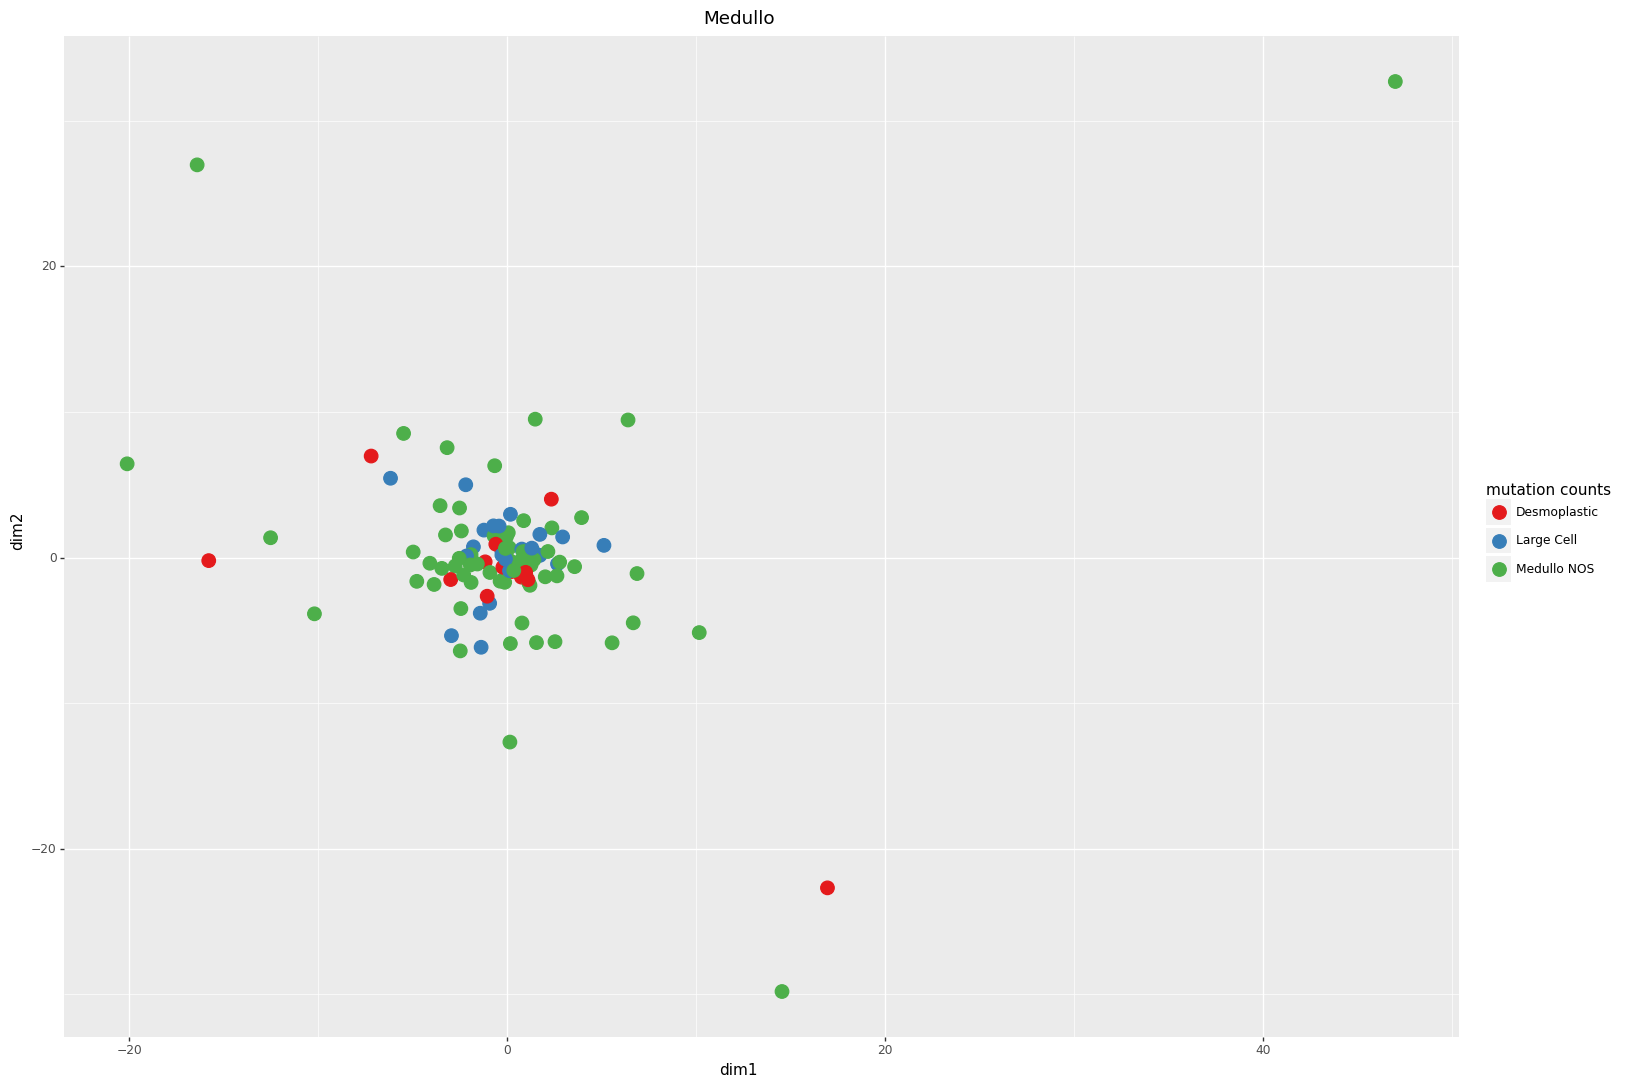

In [98]:
PBCA_DE = get_per_cohort_mutations("PBCA-DE")
icgc_specimen_df = pd.read_csv("specimen.PBCA-DE.tsv.gz", sep="\t")
icgc_specimen_df = icgc_specimen_df[icgc_specimen_df["icgc_donor_id"].isin(
                                                   PBCA_DE.index.to_numpy())]
astrocytoma_donor_ids = pd.unique(icgc_specimen_df[icgc_specimen_df["tumour_histological_type"] 
                                  == "9421/1"]["icgc_donor_id"])

astrocytoma_df = icgc_specimen_df[icgc_specimen_df["icgc_donor_id"].isin(
                                                            astrocytoma_donor_ids)]
pd.unique(astrocytoma_df["tumour_histological_type"])
medulloblastoma_df = PBCA_DE[~PBCA_DE.index.isin(astrocytoma_donor_ids)]
pd.value_counts(icgc_specimen_df["tumour_histological_type"])
desmoplastic_medullo_dIDs = pd.unique(icgc_specimen_df[icgc_specimen_df[
                                                    "tumour_histological_type"] == 
                                                    "9471/3"]["icgc_donor_id"])
largecell_medullo_dIDs = pd.unique(icgc_specimen_df[icgc_specimen_df[
                                                    "tumour_histological_type"] == 
                                                    "9474/3"]["icgc_donor_id"])

medullo_NOS_dIDs =  pd.unique(icgc_specimen_df[icgc_specimen_df[
                                                    "tumour_histological_type"] == 
                                                    "9470/3"]["icgc_donor_id"])


desmoplastic_map = medulloblastoma_df.loc[desmoplastic_medullo_dIDs].index.to_series()
desmoplastic_map[:] = "Desmoplastic"

largecell_map = medulloblastoma_df.loc[largecell_medullo_dIDs].index.to_series()
largecell_map[:] = "Large Cell"

medullo_NOS_map = medulloblastoma_df.loc[medullo_NOS_dIDs].index.to_series()
medullo_NOS_map[:] = "Medullo NOS"

index_to_subtype_map = pd.concat((desmoplastic_map, largecell_map, medullo_NOS_map))
index_to_subtype_map.name = "subtype"
medulloblastoma_df = medulloblastoma_df.merge(index_to_subtype_map, 
                                              right_index=True, left_index=True).reset_index(drop=True)
model = perform_analysis(df=medulloblastoma_df, 
                         bottom_n_remove=30, 
                         n_highest_var_feats=2128, 
                         method="PCA", 
                         n_components=2, 
                         scale=True, 
                         normalize_by_mut_counts=True, 
                         dims_to_plot=["dim1", "dim2"], 
                         plot_title="Medullo",
                         subtype_by_color=True)

In [99]:
medulloblastoma_df.to_csv("../data/processed_data/mutations_with_subtypes/medulloblastoma.csv", index=False)

In [100]:
map_to_good_names = {"Desmoplastic": "medullo_desmoplastic", "Large Cell":"medullo_large_cell"}

In [101]:
save_aggregated_subtyped_mutations(medulloblastoma_df, map_to_good_names)

# Melanoma Subtypes

<ipython-input-47-e14bb98b2dad>:178: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.


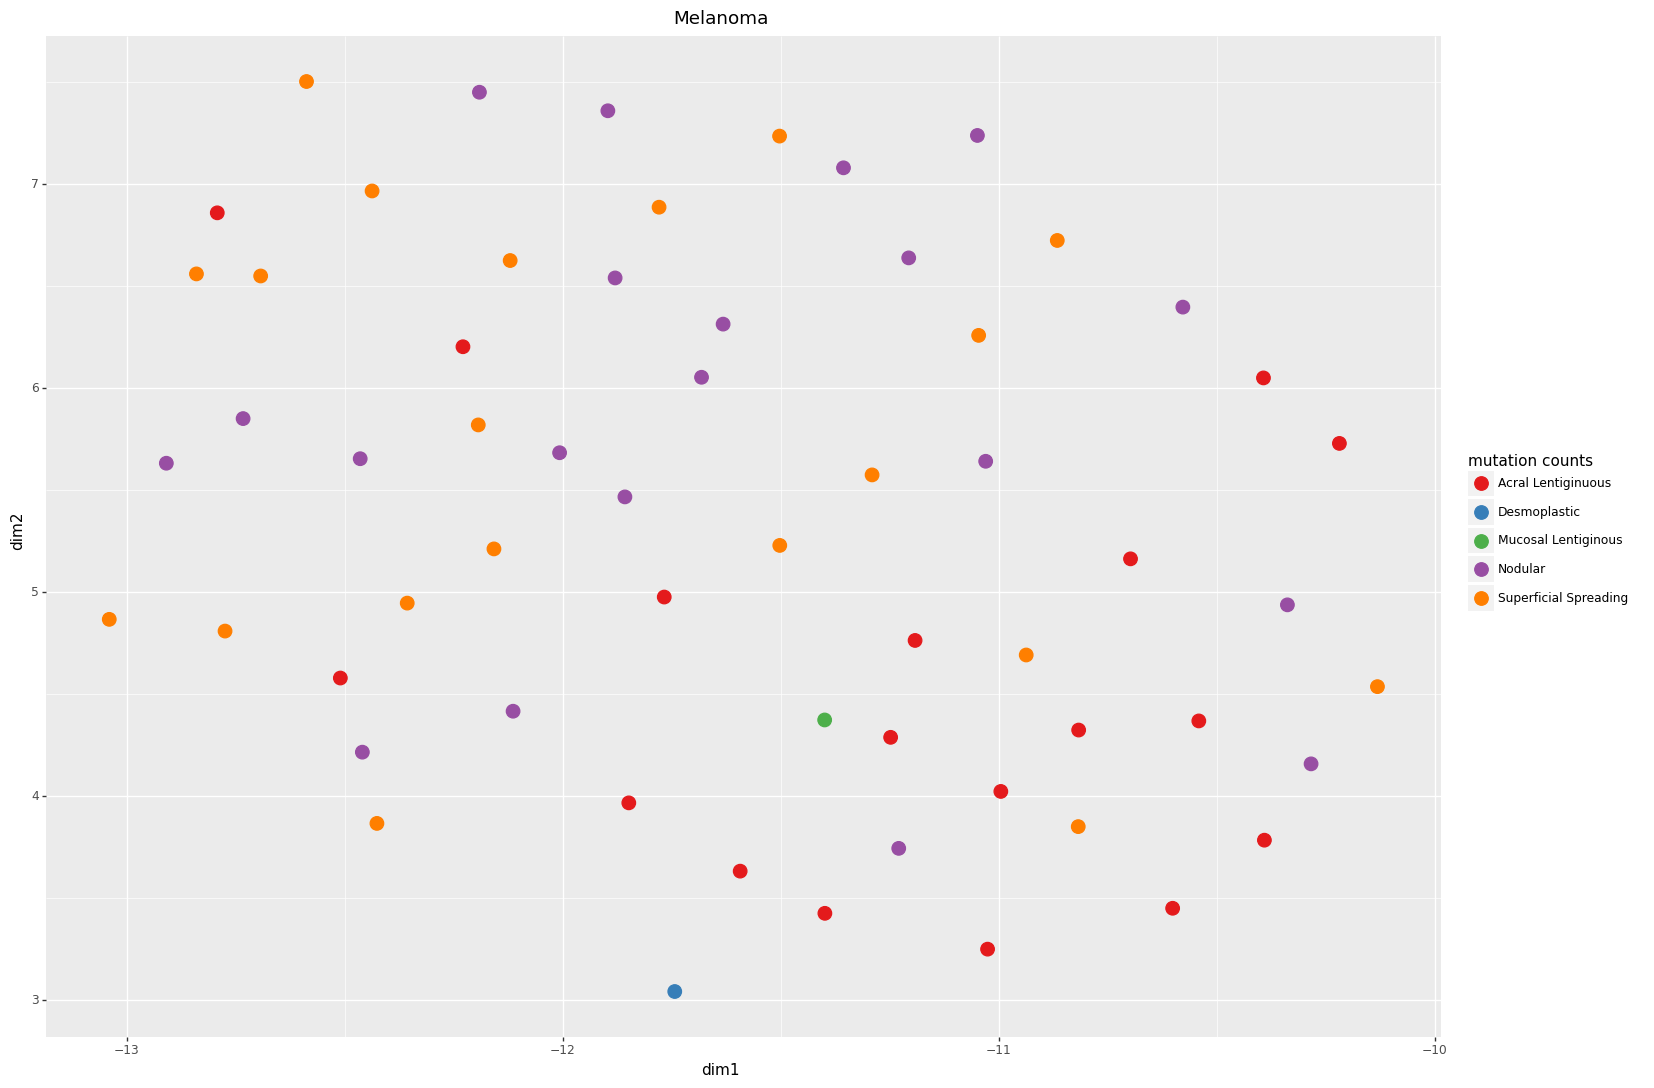

In [68]:
MELA_AU = get_per_cohort_mutations("MELA-AU")
icgc_specimen_df = pd.read_csv("../data/specimen.MELA-AU.tsv", sep="\t")
icgc_specimen_df = icgc_specimen_df[icgc_specimen_df["icgc_donor_id"].isin(
                                                   MELA_AU.index.to_numpy())]
pd.value_counts(icgc_specimen_df["tumour_histological_type"])

nodular_dIDs = pd.unique(icgc_specimen_df[icgc_specimen_df[
                                                    "tumour_histological_type"] == 
                                                    "8721/3"]["icgc_donor_id"])
superficial_spreading_dIDs = pd.unique(icgc_specimen_df[icgc_specimen_df[
                                                    "tumour_histological_type"] == 
                                                    "8743/3"]["icgc_donor_id"])
acral_lentiginous_dIDs =  pd.unique(icgc_specimen_df[icgc_specimen_df[
                                                    "tumour_histological_type"] == 
                                                    "8744/3"]["icgc_donor_id"])
mucosal_lentiginous_dIDs =  pd.unique(icgc_specimen_df[icgc_specimen_df[
                                                    "tumour_histological_type"] == 
                                                    "8746/3"]["icgc_donor_id"])
desmoplastic_dIDs =  pd.unique(icgc_specimen_df[icgc_specimen_df[
                                                    "tumour_histological_type"] == 
                                                    "8745/3"]["icgc_donor_id"])
nodular_map = MELA_AU.loc[nodular_dIDs].index.to_series()
nodular_map[:] = "Nodular"

superficial_spreading_map = MELA_AU.loc[superficial_spreading_dIDs].index.to_series()
superficial_spreading_map[:] = "Superficial Spreading"

acral_lentiginous_map = MELA_AU.loc[acral_lentiginous_dIDs].index.to_series()
acral_lentiginous_map[:] = "Acral Lentiginuous"

mucosal_lentiginous_map = MELA_AU.loc[mucosal_lentiginous_dIDs].index.to_series()
mucosal_lentiginous_map[:] = "Mucosal Lentiginous"

desmoplastic_map = MELA_AU.loc[desmoplastic_dIDs].index.to_series()
desmoplastic_map[:] = "Desmoplastic"

index_to_subtype_map = pd.concat((nodular_map, superficial_spreading_map, 
                                  acral_lentiginous_map, mucosal_lentiginous_map,
                                 desmoplastic_map))
index_to_subtype_map.name = "subtype"
MELA_AU = MELA_AU.merge(index_to_subtype_map,right_index=True, left_index=True).reset_index(drop=True)
model = perform_analysis(df=MELA_AU, 
                         bottom_n_remove=0, 
                         n_highest_var_feats=2128, 
                         method="UMAP", 
                         n_components=2, 
                         scale=False, 
                         normalize_by_mut_counts=True, 
                         dims_to_plot=["dim1", "dim2"], 
                         plot_title="Melanoma",
                         subtype_by_color=True)

# Kidney Subtypes

In [103]:
KIRC_US = prep_pre_cohort_grouping_df("KIRC-US", rosa_annotations, "KIRC_US_TCGA_ids_DonorID.csv")
RECA_EU = prep_pre_cohort_grouping_df("RECA-EU", rosa_annotations, "RECA_EU_ids_DonorID.csv")
KIRP_US = prep_pre_cohort_grouping_df("KIRP-US", rosa_annotations, "KIRP_US_TCGA_ids_DonorID.csv")
KICH_US = prep_pre_cohort_grouping_df("KICH-US", rosa_annotations, "KICH_US_TCGA_ids_DonorID.csv")

<ipython-input-93-eefe1d06eded>:178: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.


PCA(n_components=2)

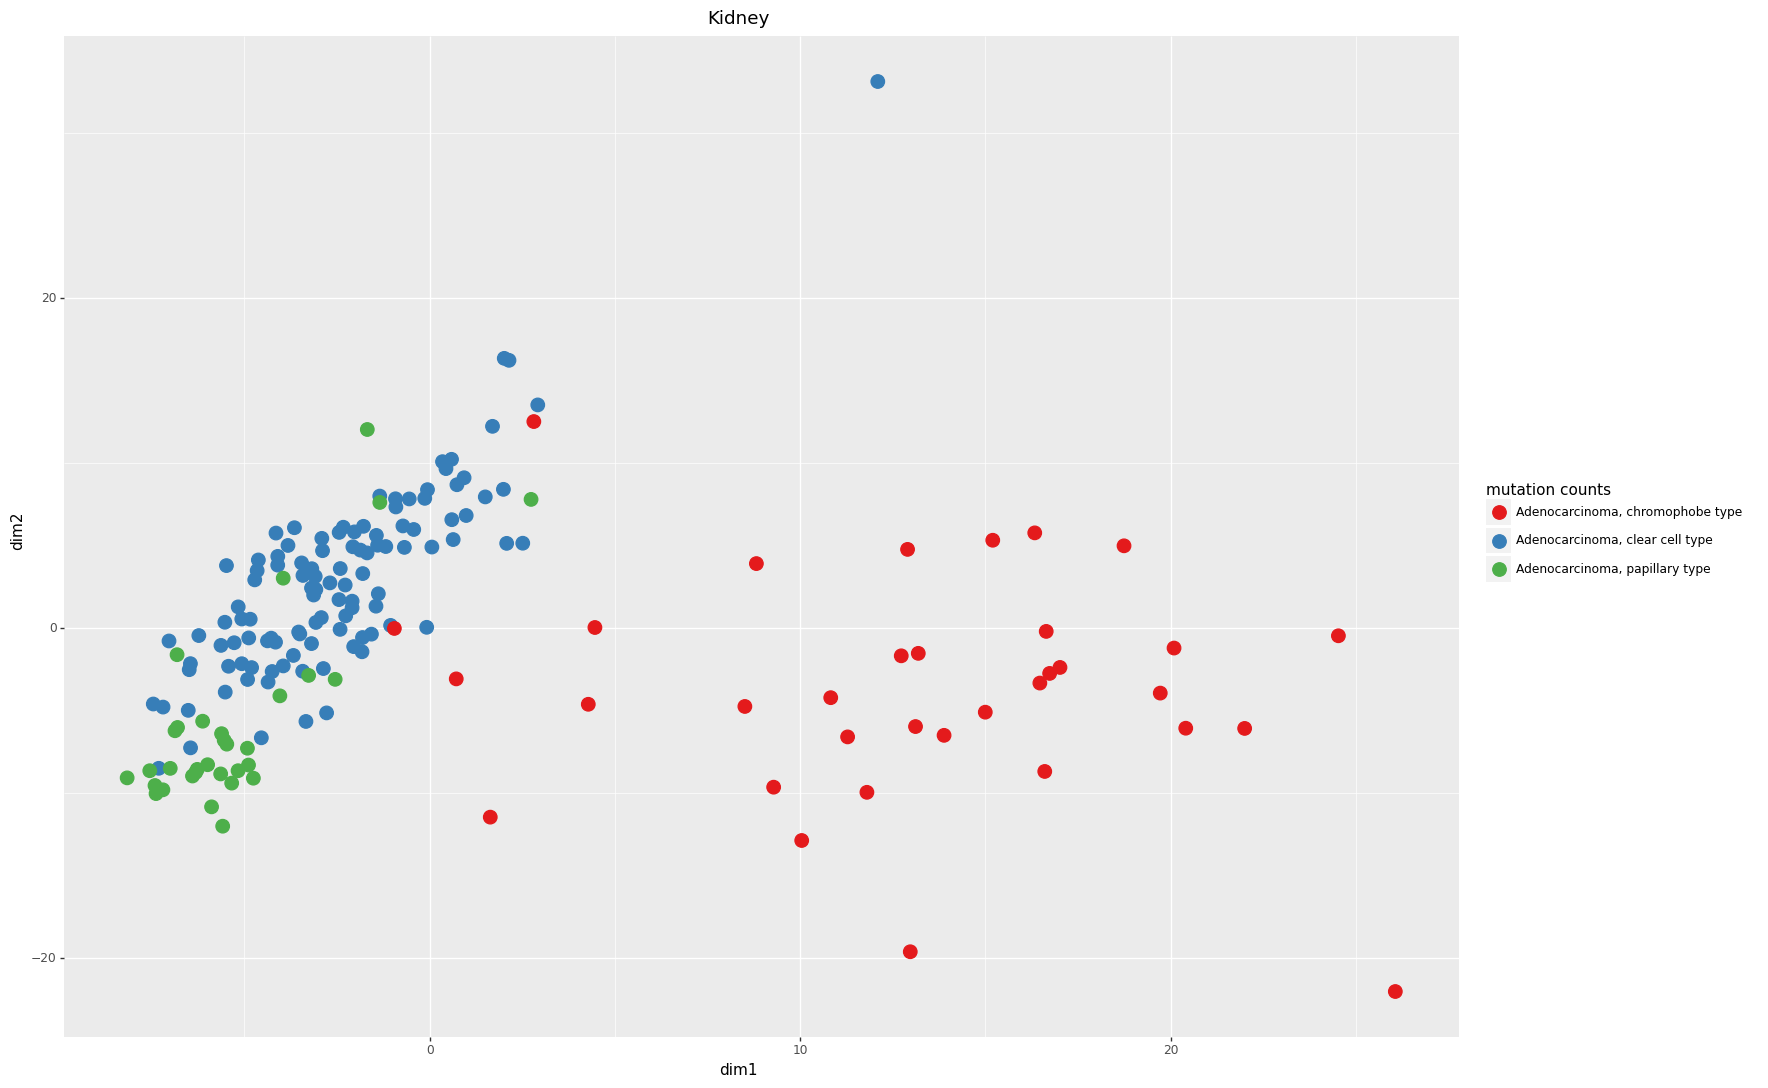

In [104]:
kidney_subtypes = create_cohort_df([KIRC_US, RECA_EU, KIRP_US, KICH_US])
perform_analysis(df=kidney_subtypes, 
                 bottom_n_remove=10, 
                 n_highest_var_feats=2128, 
                 method="PCA", 
                 n_components=2, 
                 scale=True, 
                 normalize_by_mut_counts=True, 
                 dims_to_plot=["dim1", "dim2"], 
                 plot_title="Kidney",
                 subtype_by_color=True)

In [50]:
kidney_subtypes.to_csv("../data/processed_data/mutations_with_subtypes/kidney_all.csv", index=False)

<ipython-input-93-eefe1d06eded>:178: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.


UMAP(random_state=1, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

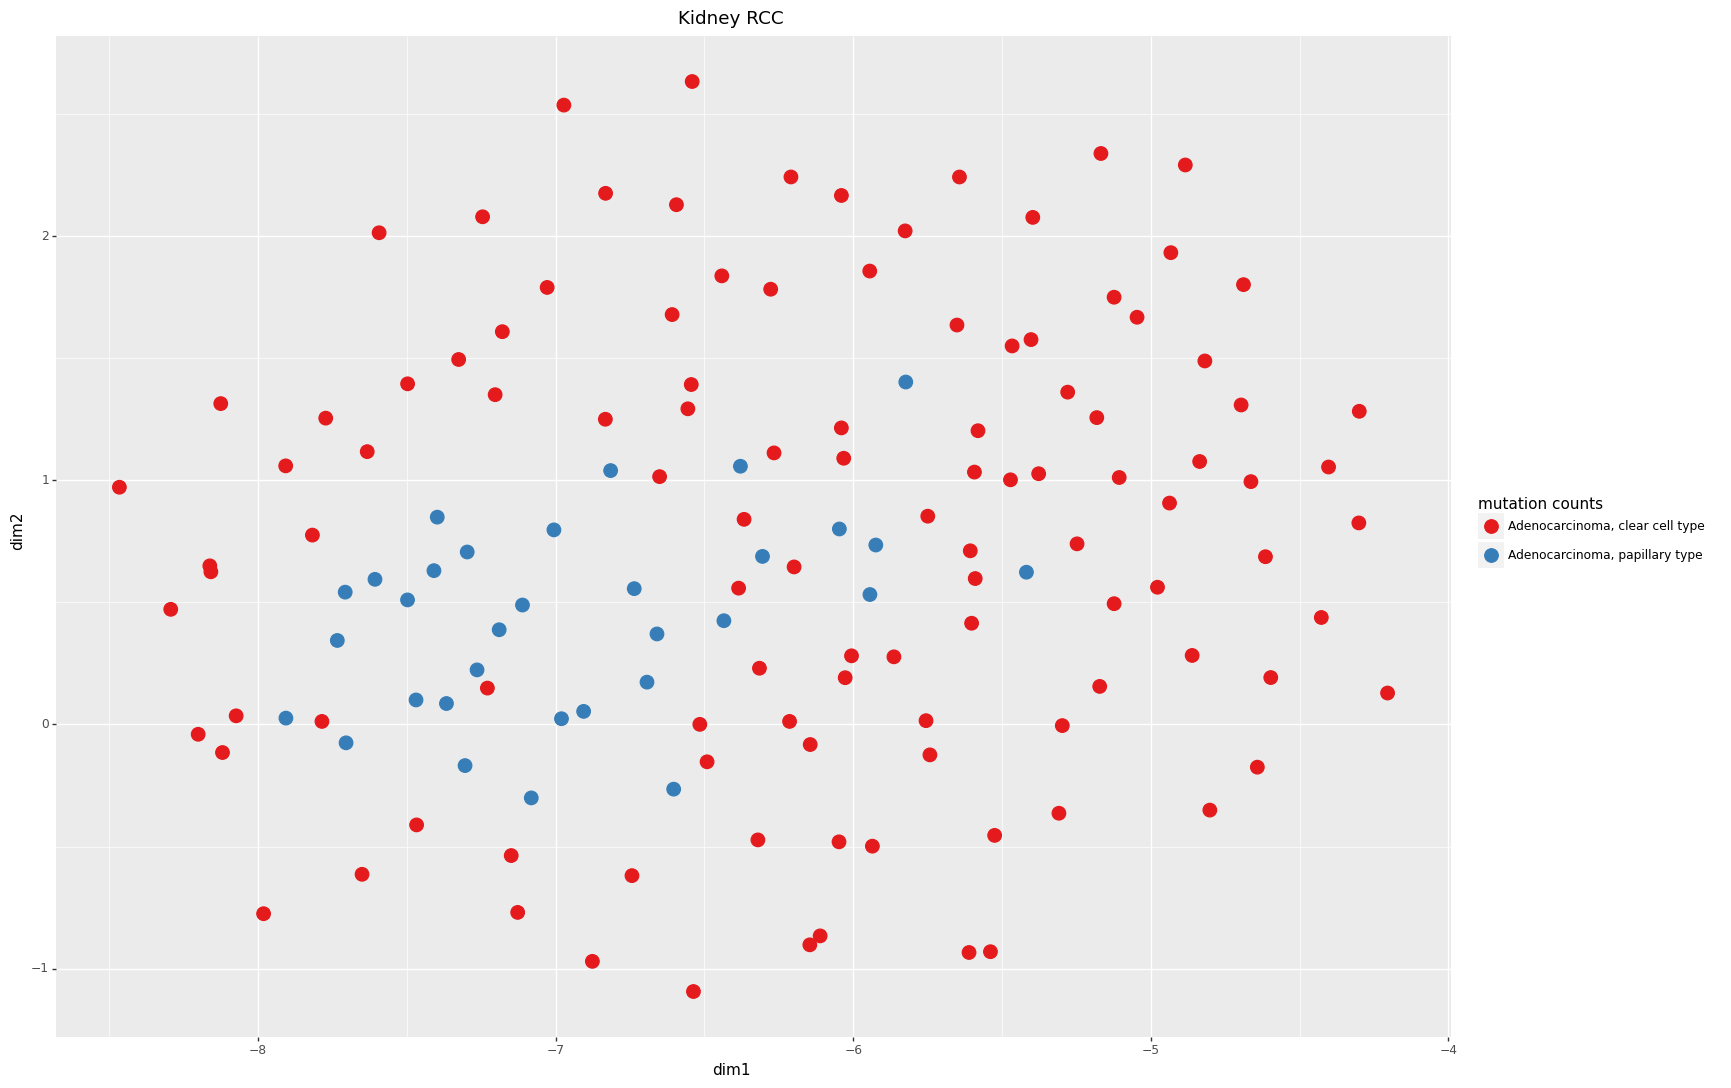

In [105]:
kidney_rcc = create_cohort_df([KIRC_US, RECA_EU, KIRP_US])
perform_analysis(df=kidney_rcc, 
                 bottom_n_remove=0, 
                 n_highest_var_feats=2128, 
                 method="UMAP", 
                 n_components=2, 
                 scale=True, 
                 normalize_by_mut_counts=True, 
                 dims_to_plot=["dim1", "dim2"], 
                 plot_title="Kidney RCC",
                 subtype_by_color=True)

In [106]:
map_to_good_names = {"Adenocarcinoma, clear cell type": "kidney_clear_cell",
                     "Adenocarcinoma, papillary type": "kidney_papillary"}
save_aggregated_subtyped_mutations(kidney_rcc, map_to_good_names)

In [12]:
KIRC_US.index = KIRC_US.index + " KIRC"

In [13]:
RECA_EU.index = RECA_EU.index + " RECA_EU"

In [91]:
kidney_same_type = create_cohort_df([KIRC_US, RECA_EU])

<ipython-input-79-eefe1d06eded>:178: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.


PCA(n_components=2)

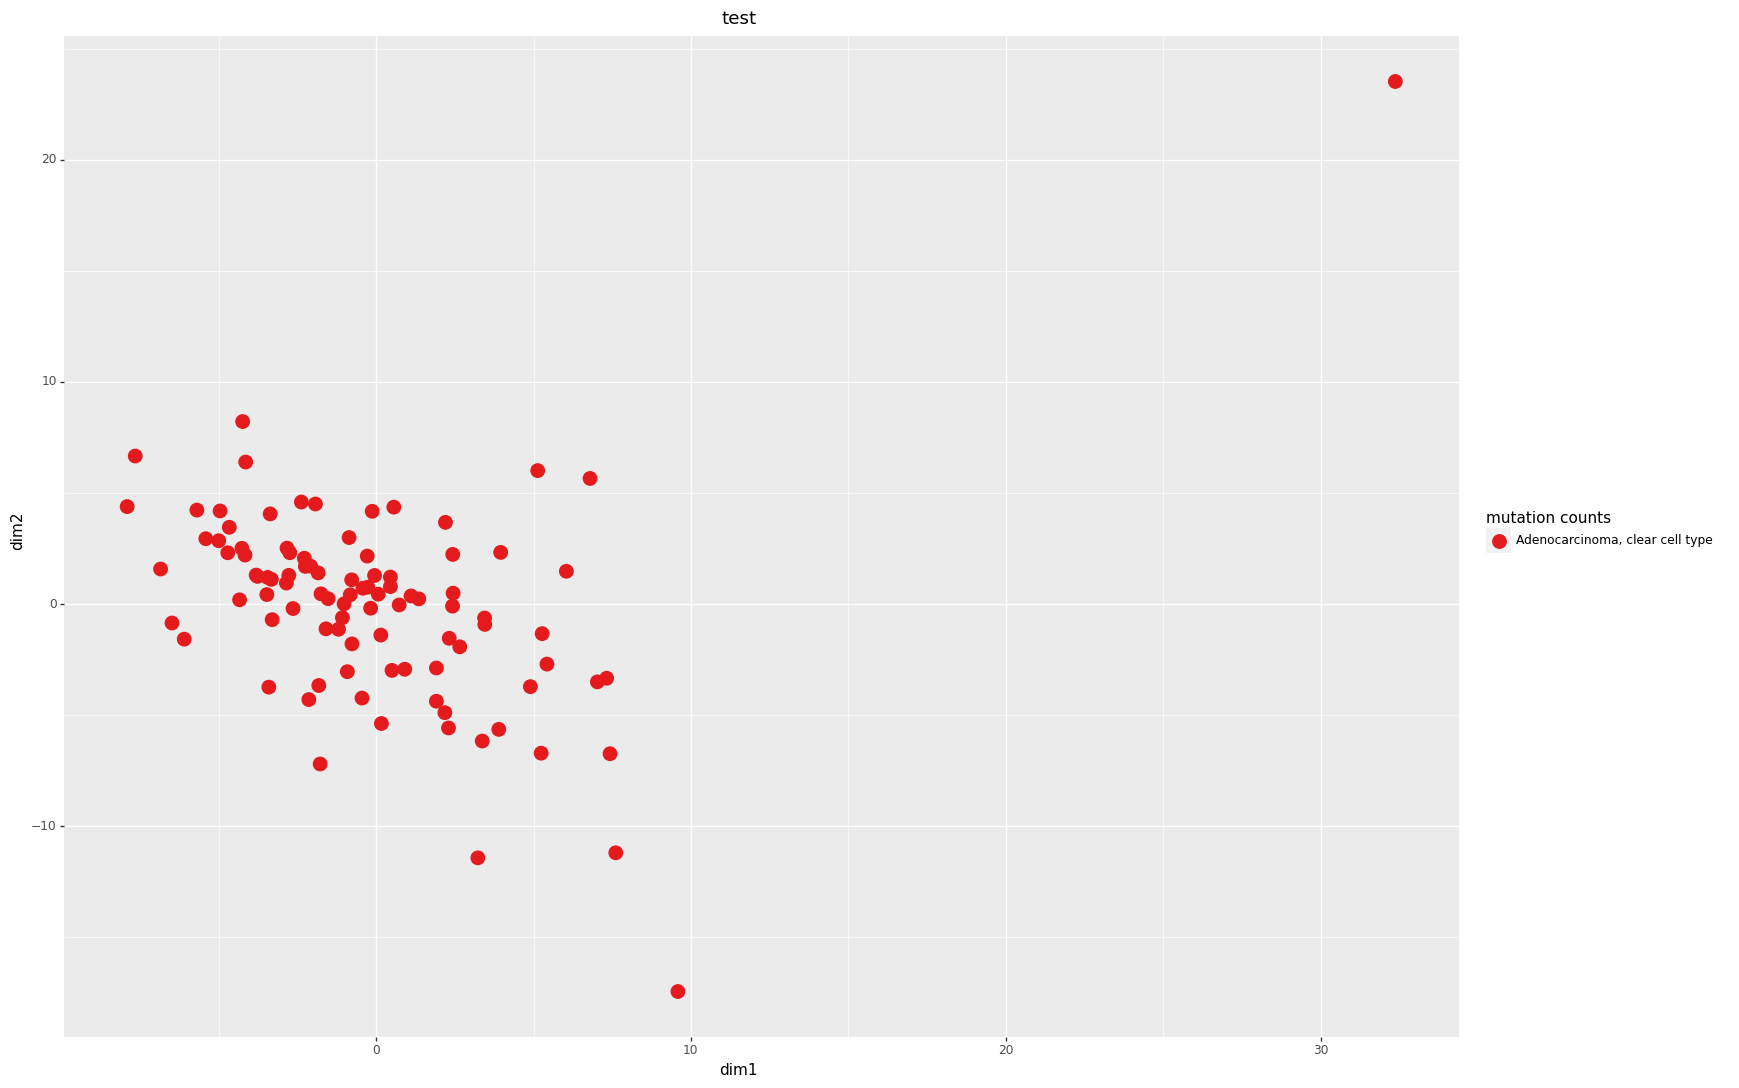

In [92]:
perform_analysis(df=kidney_same_type, 
                 bottom_n_remove=15, 
                 n_highest_var_feats=1000, 
                 method="PCA", 
                 n_components=2, 
                 scale=True, 
                 normalize_by_mut_counts=True, 
                 dims_to_plot=["dim1", "dim2"], 
                 plot_title="test",
                 subtype_by_color=True)

# Pancreas Subtypes

In [79]:
PAEN_AU_donors = pd.read_csv("../data/donor.PAEN-AU.tsv.gz", sep="\t")
PACA_AU_donors = pd.read_csv("../data/donor.PACA-AU.tsv.gz", sep="\t")
PACA_CA_donors = pd.read_csv("../data/donor.PACA-CA.tsv.gz", sep="\t")
PAEN_IT_donors = pd.read_csv("../data/donor.PAEN-IT.tsv.gz", sep="\t")

PAEN_AU_donors = PAEN_AU_donors[["icgc_donor_id", "submitted_donor_id"]]
PAEN_AU_donors.columns = ["donor_unique_id", "DonorID"]
PAEN_AU_donors = PAEN_AU_donors[["DonorID", "donor_unique_id"]]
PAEN_AU_donors.to_csv("../data/PAEN_AU_ids_DonorID.csv", index=False, sep="\t")

PACA_AU_donors = PACA_AU_donors[["icgc_donor_id", "submitted_donor_id"]]
PACA_AU_donors.columns = ["donor_unique_id", "DonorID"]
PACA_AU_donors = PACA_AU_donors[["DonorID", "donor_unique_id"]]
PACA_AU_donors.to_csv("../data/PACA_AU_ids_DonorID.csv", index=False, sep="\t")

PACA_CA_donors = PACA_CA_donors[["icgc_donor_id", "submitted_donor_id"]]
PACA_CA_donors.columns = ["donor_unique_id", "DonorID"]
PACA_CA_donors = PACA_CA_donors[["DonorID", "donor_unique_id"]]
PACA_CA_donors.to_csv("../data/PACA_CA_ids_DonorID.csv", index=False, sep="\t")

PAEN_IT_donors = PAEN_IT_donors[["icgc_donor_id", "submitted_donor_id"]]
PAEN_IT_donors.columns = ["donor_unique_id", "DonorID"]
PAEN_IT_donors = PAEN_IT_donors[["DonorID", "donor_unique_id"]]
PAEN_IT_donors.to_csv("../data/PAEN_IT_ids_DonorID.csv", index=False, sep="\t")

In [81]:
PAEN_AU = prep_pre_cohort_grouping_df("PAEN-AU", rosa_annotations, "PAEN_AU_ids_DonorID.csv")
PACA_AU = prep_pre_cohort_grouping_df("PACA-AU", rosa_annotations, "PACA_AU_ids_DonorID.csv")
PACA_CA = prep_pre_cohort_grouping_df("PACA-CA", rosa_annotations, "PACA_CA_ids_DonorID.csv")
PAEN_IT = prep_pre_cohort_grouping_df("PAEN-IT", rosa_annotations, "PAEN_IT_ids_DonorID.csv")

In [83]:
rosa_annotations = pd.read_csv("../data/rosa_annotations.csv")
rosa_annotations = separate_rosa_cohort_and_donor_ids(rosa_annotations)

In [43]:
cohort = "PACA-CA"

In [44]:
df = get_per_cohort_mutations(cohort)

In [45]:
specimen_df = pd.read_csv(f"../data/specimen.{cohort}.tsv", sep="\t")

In [46]:
donor_ids = get_donors_by_cohort_rosa_df(rosa_annotations, cohort)["donor"]

In [47]:
prev_ids_to_ICGC = pd.read_csv(f"../data/{mapped_icgc_id_file}", sep="\t")
prev_ids_to_ICGC.columns = ["rosa_donor", "ICGC_donor"]

NameError: name 'mapped_icgc_id_file' is not defined

In [48]:
prev_ids_to_ICGC_id = get_idx_to_ICGC_map(rosa_annotations, cohort, prev_ids_to_ICGC)

NameError: name 'prev_ids_to_ICGC' is not defined

In [305]:
rosa_annotations.loc[prev_ids_to_ICGC_id.index, "ICGC_donor_id"] = prev_ids_to_ICGC_id

In [307]:
annotation_df = prep_annotation_df(rosa_annotations, cohort)

In [311]:
annotation_df["subtype"].value_counts()

Pancreatic ductal carcinoma    81
Adenocarcinoma                 60
Adenocarcinoma, mucinous        2
Anaplastic carcinoma            1
Name: subtype, dtype: int64

In [314]:
df

,chr1.5,chr1.6,chr1.7,chr1.8,chr1.9,chr1.11,chr1.12,chr1.15,chr1.16,chr1.19,...,chr9.123,chr9.124,chr9.125,chr9.126,chr9.127,chr9.131,chr9.132,chr9.133,chr9.135,chr9.137
DO51468,3,3,0,0,0,0,1,3,1,4,...,0,1,5,1,1,1,1,0,5,0
DO51484,3,0,1,0,0,0,2,0,1,1,...,3,2,1,0,0,0,2,2,1,0
DO49422,3,4,1,1,1,1,1,3,1,0,...,1,2,1,4,0,2,0,1,2,5
DO51490,4,1,0,2,0,0,0,0,1,1,...,0,2,3,1,0,3,1,0,5,2
DO51486,3,6,2,0,3,5,2,3,2,2,...,0,4,4,2,1,4,5,4,3,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DO51495,3,4,5,5,2,4,1,6,5,7,...,1,1,3,4,3,6,6,3,6,3
DO51514,6,7,0,3,2,5,2,1,1,0,...,1,1,1,1,0,7,2,1,1,0
DO51536,4,1,3,2,1,3,1,2,6,1,...,1,1,0,1,0,0,3,1,6,1
DO35454,2,3,3,0,1,1,2,1,0,1,...,2,0,0,1,1,0,1,0,4,2


In [53]:
not_in_rosa = df[~df.index.isin(annotation_df.index)]

NameError: name 'annotation_df' is not defined

In [327]:
not_in_ours = annotation_df[~annotation_df.index.isin(df.index)]

In [35]:
not_in_ours

NameError: name 'not_in_ours' is not defined

In [329]:
not_in_rosa

,chr1.5,chr1.6,chr1.7,chr1.8,chr1.9,chr1.11,chr1.12,chr1.15,chr1.16,chr1.19,...,chr9.123,chr9.124,chr9.125,chr9.126,chr9.127,chr9.131,chr9.132,chr9.133,chr9.135,chr9.137
DO49454,2,1,1,2,0,0,0,5,1,0,...,0,0,0,1,1,0,2,1,5,2
DO49442,5,2,0,2,0,2,1,1,2,0,...,1,3,0,0,2,1,1,0,1,1


In [ ]:
df = group_donors_by_subtype(df, annotation_df)

In [84]:
PACA_CA["provenance"] = "PACA-CA"

In [85]:
PACA_AU["provenance"] = "PACA-AU"

In [86]:
PAEN_AU["provenance"] = "PAEN-AU"

In [87]:
PAEN_IT["provenance"] = "PAEN-IT"

In [69]:
pd.unique(PAEN_AU.index)

array(['Neoroendocrine carcinoma'], dtype=object)

In [70]:
pd.unique(PACA_AU.index)

array(['Pancreatic ductal carcinoma', 'Carcinoma, adenosquamous',
       'Invasive carcinoma arising in IPMN', 'Adenocarcinoma, mucinous',
       'Acinar cell carcinoma'], dtype=object)

In [71]:
pd.unique(PACA_CA.index)

array(['Adenocarcinoma', 'Pancreatic ductal carcinoma', nan,
       'Adenocarcinoma, mucinous'], dtype=object)

In [72]:
pd.unique(PAEN_IT.index)

array(['Neoroendocrine carcinoma'], dtype=object)

In [ ]:
pancreas_adeno = create_cohort_df([PACA_AU, PACA_CA])

In [33]:
pancreas_endocrine = create_cohort_df([PAEN_AU])

In [32]:
pancreas_endocrine.sum()[1:2129].sum()

93387

In [34]:
perform_analysis(df=pancreas_adeno, 
                 bottom_n_remove=10, 
                 n_highest_var_feats=2128, 
                 method="PCA", 
                 n_components=2, 
                 scale=True, 
                 normalize_by_mut_counts=True, 
                 dims_to_plot=["dim1", "dim2"], 
                 plot_title="Pancreas Adeno",
                 subtype_by_color=True)

NameError: name 'pancreas_adeno' is not defined

In [56]:
map_to_good_names = {"Pancreatic ductal carcinoma": "pancreatic_ductal",
                     "Carcinoma, adenosquamous": "pancreatic_adenosquamous",
                     "Invasive carcinoma arising in IPMN": "pancreatic_invasive_IPMN",
                     "Adenocarcinoma, mucinous": "pancreatic_mucinuous",
                     "Acinar cell carcinoma": "pancreatic_acinar_cell",
                    }

In [48]:
pancreas_histology = pancreas_adeno.loc[pancreas_adeno["subtype"].isin(map_to_good_names)]

In [43]:
save_aggregated_subtyped_mutations(pancreas_histology, map_to_good_names)

<ipython-input-37-d85a5fadc125>:246: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-37-d85a5fadc125>:247: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


In [57]:
pancreas_adeno.to_csv("../data/processed_data/mutations_with_subtypes/pancreas_adeno.csv", index=False)

In [73]:
pancreas = create_cohort_df([PACA_AU, PACA_CA, PAEN_AU])
# model = perform_analysis(df=pancreas, 
#                  bottom_n_remove=40, 
#                  n_highest_var_feats=2128, 
#                  method="UMAP", 
#                  n_components=2, 
#                  scale=True, 
#                  normalize_by_mut_counts=True, 
#                  dims_to_plot=["dim1", "dim2"], 
#                  plot_title="pancreas",
#                  subtype_by_color=True)

In [75]:
pancreas.to_csv("../data/processed_data/mutations_with_subtypes/pancreas_all.csv", index=False)

In [15]:
model.explained_variance_ratio_

array([0.02703699, 0.01396376])

In [910]:
df = pd.DataFrame(np.sum(pancreas_adeno, axis=0))
df.columns = ["mut_counts"]

/home/mdanb/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.


In [28]:
from natsort import natsorted

In [29]:
s = pd.DataFrame(natsorted(df.index))

NameError: name 'df' is not defined

In [30]:
s.columns = ["chr"]

NameError: name 's' is not defined

In [31]:
df = pd.DataFrame(s.merge(df, left_on="chr", right_index=True))

NameError: name 's' is not defined

In [32]:
df.to_csv("df.csv")

NameError: name 'df' is not defined

In [998]:
(
ggplot(df) + 
    geom_histogram(aes(x=df.iloc[:,0], y=df.iloc[:,1]), stat="identity") +
    labs(color="mutation counts") +
    theme(figure_size=(18, 13))
)

KeyError: 'width'

In [88]:
pancreas_neuroendocrine = create_cohort_df([PAEN_IT, PAEN_AU])

In [90]:
pancreas_neuroendocrine

,subtype,donor_id,chr1.5,chr1.6,chr1.7,chr1.8,chr1.9,chr1.11,chr1.12,chr1.15,...,chr9.124,chr9.125,chr9.126,chr9.127,chr9.131,chr9.132,chr9.133,chr9.135,chr9.137,provenance
0,Neoroendocrine carcinoma,DO52152,0,1,0,0,2,0,0,1,...,3,1,0,2,1,1,0,0,1,PAEN-IT
1,Neoroendocrine carcinoma,DO52136,1,5,1,0,1,0,2,0,...,0,0,0,7,1,1,1,3,0,PAEN-IT
2,Neoroendocrine carcinoma,DO52139,1,0,1,0,1,0,2,1,...,0,3,0,1,0,0,0,4,0,PAEN-IT
3,Neoroendocrine carcinoma,DO52134,0,0,1,0,0,0,1,0,...,1,0,1,0,1,1,0,1,2,PAEN-IT
4,Neoroendocrine carcinoma,DO52146,1,1,1,0,0,1,2,2,...,0,1,0,2,2,4,3,3,2,PAEN-IT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,Neoroendocrine carcinoma,DO46755,2,0,0,2,0,0,1,1,...,5,0,1,0,0,1,0,0,3,PAEN-AU
77,Neoroendocrine carcinoma,DO46773,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,PAEN-AU
78,Neoroendocrine carcinoma,DO46771,0,2,2,0,0,1,0,0,...,0,0,0,0,0,1,0,1,0,PAEN-AU
79,Neoroendocrine carcinoma,DO51187,2,0,1,2,1,0,2,1,...,1,2,0,1,2,0,3,4,1,PAEN-AU


In [78]:
pancreas_neuroendocrine.to_csv("../data/processed_data/mutations_with_subtypes/pancreas_neuroendocrine.csv", index=False)

In [755]:
# PAEN_AU = get_per_cohort_mutations("PAEN-AU")
# PACA_AU = get_per_cohort_mutations("PACA-AU")
# PACA_CA = get_per_cohort_mutations("PACA-CA")
# PAEN_AU_specimen_df = pd.read_csv("../data/specimen.PAEN-AU.tsv.gz", sep="\t")
# PACA_AU_specimen_df = pd.read_csv("../data/specimen.PACA-AU.tsv", sep="\t")
# PACA_CA_specimen_df = pd.read_csv("../data/specimen.PACA-CA.tsv", sep="\t")